In [2]:
try:
    import torch
except:
    print("[INFO] Couldn't find torch... installing it.")
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch

try:
    import torchmetrics
except:
    print("[INFO] Couldn't find torchmetrics... installing it.")
    !pip install torchmetrics
    import torchmetrics

try:
    import torchinfo
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install torchinfo
    import torchinfo

try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter

try: 
    import wandb
except: 
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install wandb


import sys
import os
import random
from typing import Dict, Tuple, List, Set, Union, Type, Literal
from itertools import product
from dataclasses import dataclass
from collections import Counter
import re
from pathlib import Path

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path

# --- Importing Formula Class ---
# Go two levels up: from ICTCS_notebooks → theorem_prover_core → project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from theorem_prover_core.formula import (Formula, Letter, Falsity, Conjunction, Disjunction, Implication,
                                         Negation, BinaryConnectiveFormula, UnaryConnectiveFormula, bottom)

from logic_utils import Normalizer, Metavariable, Normalizer, CustomTokenizer, assign_embedding_indices, print_tree_with_embeddings
from data_setup import (generate_normalized_dataset, add_new_tautologies_to_dataset, parse_dimacs_files, prepare_formula_dataset, 
                        FormulaDataset, FormulaTreeNode, prepare_balanced_tree_dataloaders, prepare_tree_dataloaders)
from train_utils import (set_seeds, compute_vocab_size, train, save_results, save_model, train_tree, eval_model, analyze_model_errors,
                         evaluate_confusion_matrix, count_parameters)
from models import AsymmetricFocalLoss, TreeLSTMClassifierV1, TreeLSTMClassifierV2

## **Part 1: GRU**

---
#### **Set up device-agnostic code**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

---
### **1 Generate Synthetic Datasets**

#### **1.1 Normalized Dataset**

In [4]:
# --- Generating normalized dataset ---
SIZE = 10000
MAX_DEPTH = 5
NUM_LETTERS = 7
SEED = 42

random.seed(SEED)
data_set = generate_normalized_dataset(num_formulas=SIZE, 
                                      max_depth=MAX_DEPTH,
                                      num_letters=NUM_LETTERS)

datapath = "datasets/normalized_formulas_dataset.csv"
data_set.to_csv(datapath, index=False)
print("\n" + "=" * 130)
print(f"[INFO] Saving Dataset to {os.path.abspath(datapath)}")
print("=" * 130 + "\n")


[INFO] Saving Dataset to /home/labeconomia/nbalestra/theorem_prover/theorem_prover_core/ICTCS_notebooks/datasets/normalized_formulas_dataset.csv



In [5]:
data_set.head()

,formula,is_tautology
0,A0,False
1,((A0 ∧ (¬((A1 ∧ A2) ∧ A3))) ∨ (A4 → A5)),False
2,(((¬(A0 → A1)) → A2) ∨ A3),False
3,(⊥ ∨ A0),False
4,(¬A0),False


In [6]:
print(data_set.count())
count = data_set.is_tautology.value_counts()
print(f"\nNumber of True and False formulas: \n{count}\n")

total = len(data_set)
tautologies = data_set["is_tautology"].sum()
percentage = (tautologies / total) * 100
print(f"Percentage of tautologies in the dataset: {percentage:.2f}%")

formula         10000
is_tautology    10000
dtype: int64

Number of True and False formulas: 
is_tautology
False    9582
True      418
Name: count, dtype: int64

Percentage of tautologies in the dataset: 4.18%


#### **1.2 Data Augmentation With Common Tautologies Instantiation**

In [7]:
# --- Creating Common Tautologies --- 
A = Metavariable("A")
B = Metavariable("B")
C = Metavariable("C")

# List of common tautologies
tautologies = [

    Disjunction(A, Negation(A)),

    Negation(Conjunction(A, Negation(A))),

    Conjunction(
        Implication(Negation(Conjunction(A, B)), Disjunction(Negation(A), Negation(B))),
        Implication(Disjunction(Negation(A), Negation(B)), Negation(Conjunction(A, B)))
    ),

    Conjunction(
        Implication(Negation(Disjunction(A, B)), Conjunction(Negation(A), Negation(B))),
        Implication(Conjunction(Negation(A), Negation(B)), Negation(Disjunction(A, B)))
    ),

    Conjunction(
        Implication(Conjunction(A, Disjunction(B, C)), Disjunction(Conjunction(A, B), Conjunction(A, C))),
        Implication(Disjunction(Conjunction(A, B), Conjunction(A, C)), Conjunction(A, Disjunction(B, C)))
    ),

    Conjunction(
        Implication(Disjunction(A, Conjunction(B, C)), Conjunction(Disjunction(A, B), Disjunction(A, C))),
        Implication(Conjunction(Disjunction(A, B), Disjunction(A, C)), Disjunction(A, Conjunction(B, C)))
    )
]

for tautology in tautologies:
    print(tautology)

A ∨ ¬A
¬(A ∧ ¬A)
(¬(A ∧ B) → ¬A ∨ ¬B) ∧ (¬A ∨ ¬B → ¬(A ∧ B))
(¬(A ∨ B) → ¬A ∧ ¬B) ∧ (¬A ∧ ¬B → ¬(A ∨ B))
(A ∧ (B ∨ C) → (A ∧ B) ∨ (A ∧ C)) ∧ ((A ∧ B) ∨ (A ∧ C) → A ∧ (B ∨ C))
(A ∨ (B ∧ C) → (A ∨ B) ∧ (A ∨ C)) ∧ ((A ∨ B) ∧ (A ∨ C) → A ∨ (B ∧ C))


In [8]:
# --- Adding 3,000 (30% of dataaset) new tatologies to the dataset ---
num_samples = 3000
seed_value = 42

dataset = add_new_tautologies_to_dataset(dataset=data_set,
                                         tautologies=tautologies,
                                         num_samples=num_samples,
                                         max_depth=MAX_DEPTH,
                                         num_letters=NUM_LETTERS,
                                         seed=seed_value)

datapath = "datasets/extended_dataset_with_tautologies.csv"
dataset.to_csv(datapath, index=False)
print("\n" + "=" * 130)
print(f"[INFO] Saving Dataset to {os.path.abspath(datapath)}")
print("=" * 130 + "\n")


[INFO] Saving Dataset to /home/labeconomia/nbalestra/theorem_prover/theorem_prover_core/ICTCS_notebooks/datasets/extended_dataset_with_tautologies.csv



In [9]:
# --- Get Dataset Info ---
print(dataset.count())
count = dataset.is_tautology.value_counts()
print(f"\nNumber of True and False formulas: \n{count}\n")

total = len(dataset)
tautologies = dataset["is_tautology"].sum()
percentage = (tautologies / total) * 100
print("\n" + "=" * 60)
print(f"Percentage of tautologies in the dataset: {percentage:.2f}%")
print("=" * 60 + "\n")

formula         13000
is_tautology    13000
dtype: int64

Number of True and False formulas: 
is_tautology
False    9582
True     3418
Name: count, dtype: int64


Percentage of tautologies in the dataset: 26.29%



#### **1.3 Data Augmentation With Common Tautologies Instantiation and DIMACS format formulas**

Extending Dataset with [SATLIB - Benchmark Problems](https://www.cs.ubc.ca/~hoos/SATLIB/benchm.html), using propositional formulas in Dimacs format.

Formulas Downloaded from SATLIB: 
- uf20-91: 20 variables, 91 clauses - 1000 instances, all satisfiable
- uf50-218 / uuf50-218: 50 variables, 218 clauses - 1000 instances, all sat/unsat

In [10]:
base_dir = "dimacs_formulas_datasets/"
dataset_satlib = parse_dimacs_files(base_dir=base_dir)

In [11]:
dataset_satlib.is_tautology.value_counts()

is_tautology
True     2000
False    1000
Name: count, dtype: int64

In [12]:
# --- Normalizing new formulas ---
dataset_satlib['formula'] = dataset_satlib['formula'].apply(lambda f: str(Normalizer().normalize(f)))

In [13]:
# --- Adding a column 'source' to combined dataset to distinguish between synthetic formulas and dimacs formulas ---
dataset['source'] = 'synthetic'
dataset_satlib['source'] = 'satlib'

# --- Concateating datasets and shuffling ---
dataset_composed = pd.concat([dataset, dataset_satlib], ignore_index=True)
dataset_composed = dataset_composed.sample(frac=1, random_state=42).reset_index(drop=True) # frac=1 means shuffle all rows
                                                                                           # reset_index(drop=True) removes the old index
# --- Adding indices to dataset---
dataset_composed['index'] = dataset_composed.index

datapath = "datasets/extended_dataset_with_dimacs_formulas.csv"
dataset_composed.to_csv(datapath, index=False)
print("\n" + "=" * 130)
print(f"[INFO] Saving Dataset to {os.path.abspath(datapath)}")
print("=" * 130 + "\n")


[INFO] Saving Dataset to /home/labeconomia/nbalestra/theorem_prover/theorem_prover_core/ICTCS_notebooks/datasets/extended_dataset_with_dimacs_formulas.csv



In [14]:
dataset_composed.head()

,formula,is_tautology,source,index
0,(¬(((A0 → A1) ∧ ((A2 ∨ A3) ∧ ((A4 → A5) ∧ (¬A6...,True,synthetic,0
1,(¬((A0 ∧ (((¬(A1 ∧ A2)) ∨ A3) → A4)) ∧ (¬(A0 ∧...,True,synthetic,1
2,(((A0 ∧ ((¬A1) ∧ (A2 → A3))) ∧ ((A4 ∨ A5) → A6...,False,synthetic,2
3,((A0 ∨ (¬((A1 ∧ A2) ∨ (¬A3)))) → A4),False,synthetic,3
4,(A0 ∨ (((A1 → A2) → A3) → A4)),False,synthetic,4


In [15]:
# --- Get Dataset Info ---
print(dataset_composed.count())
count = dataset_composed.is_tautology.value_counts()
print(f"\nNumber of True and False formulas: \n{count}\n")

total = len(dataset)
tautologies = dataset_composed["is_tautology"].sum()
percentage = (tautologies / total) * 100
print("\n" + "=" * 130)
print(f"Percentage of tautologies in the composed dataset: {percentage:.2f}%")
print("=" * 130 + "\n")

formula         16000
is_tautology    16000
source          16000
index           16000
dtype: int64

Number of True and False formulas: 
is_tautology
False    10582
True      5418
Name: count, dtype: int64


Percentage of tautologies in the composed dataset: 41.68%



In [16]:
TEST_SIZE = 0.2
BATCH_SIZE = 16
SEED = 42

(train_dataloader, test_dataloader, 
 tokenizer,
 X_train, X_test, 
 y_train, y_test, idx_test)  = prepare_formula_dataset(dataset = dataset,
                                                                 test_size=TEST_SIZE,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=SEED)

In [17]:
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 10400 samples
Test set: 2600 samples


In [18]:
tokenizer = CustomTokenizer()
tokenizer.fit(X_train)

num_letters = sum(1 for formula in tokenizer.formula_to_token if isinstance(formula, Letter))
num_connectives = len(tokenizer.connective_map)
num_parenthesis = sum(1 for formula in tokenizer.special_map)

print(f"Number of unique letters: {num_letters}")
print(f"Number of unique connectives: {num_connectives}")
print(f"Number of spacial tokens: {num_parenthesis}")

Number of unique letters: 8
Number of unique connectives: 4
Number of spacial tokens: 2


In [19]:
import collections

train_class_counts = collections.Counter(y_train)
test_class_counts = collections.Counter(y_test)

print(f"Train class counts: {train_class_counts}")
print(f"Test class counts: {test_class_counts}")

Train class counts: Counter({False: 7662, True: 2738})
Test class counts: Counter({False: 1920, True: 680})


In [20]:
def print_class_distribution(name: str, counter: collections.Counter):
    total = sum(counter.values())
    false_count = counter[False]
    true_count = counter[True]
    false_pct = (false_count / total) * 100
    true_pct = (true_count / total) * 100
    print(f"{name} set ({total} samples): False = {false_pct:.2f} % and True = {true_pct:.2f} %")

print_class_distribution("Train", train_class_counts)
print_class_distribution("Test", test_class_counts)

Train set (10400 samples): False = 73.67 % and True = 26.33 %
Test set (2600 samples): False = 73.85 % and True = 26.15 %


In [21]:
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f0b3944fcd0>, <torch.utils.data.dataloader.DataLoader object at 0x7f0b39448b50>)
Length of train dataloader: 650 batches of 16
Length of test dataloader: 163 batches of 16


In [22]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader)) # next() grabs the first batch from the iterator
print(f"{train_features_batch.shape, train_labels_batch.shape} -> [batch_size, num_of_tokens_per_formula], [bach_size]")

(torch.Size([16, 603]), torch.Size([16])) -> [batch_size, num_of_tokens_per_formula], [bach_size]


---
#### **2 Build, Train and Test GRU Models on Synthetic Dataset**

#### **2.1 Hyperparameters**

In [23]:
# Determine the vocabulary size for the embedding layer (add 1 for padding index 0)
VOCAB_SIZE = compute_vocab_size(tokenizer)

print(f"Vocabulary size (including padding token): {VOCAB_SIZE}")
print("Max index in batch:", train_features_batch.max().item())
assert train_features_batch.max().item() < VOCAB_SIZE, "Some token indices exceed the embedding size!"

EMBEDDING_DIM = 32
LR = 0.0005
EPOCHS = 5

Vocabulary size (including padding token): 108
Max index in batch: 107


#### **2.2 Model 1**

In [24]:
# --- Vanilla RNN Model ---
class RNN_V1(nn.Module):
    def __init__(self, vocab_size :int, embedding_dim :int, hidden_units: int, output_size :int):
        super().__init__()
        
        # Embedding layer:
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        # Simple RNN layer:
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_units, batch_first=True)
        # Fully connected output layer:
        self.linear = nn.Linear(in_features=hidden_units, out_features=output_size)
    
    def forward(self, x: torch.Tensor):
        # x shape: [batch_size, seq_len]
        x = self.embedding(x)               # [batch_size, seq_len, embed_dim]
        _, h_n = self.rnn(x)                # [num_layers, batch_size, hidden_dim] = [1, batch_size, hidden_dim]
        last_hidden = h_n.squeeze(0)        # [batch_size, hidden_dim] - remove the first dimension
        output = self.linear(last_hidden)   # [batch_size, output_size] == [32, 1]
        output = output.squeeze(1)          # Reshape output to match label shape [32]
        return output

In [25]:
model_1 = RNN_V1(vocab_size=VOCAB_SIZE, 
                 embedding_dim=EMBEDDING_DIM,
                 hidden_units=64,
                 output_size=1
).to(device) 

print(f"Model_1 is on the model device: {next(model_1.parameters()).device}")
model_1

Model_1 is on the model device: cuda:0


RNN_V1(
  (embedding): Embedding(108, 32)
  (rnn): RNN(32, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [26]:
# --- Loss and Optimizer Functions ---
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                            lr=LR)

In [27]:
# --- Get a summary of Model_1 ---
summary(model_1, 
         input_size=train_features_batch.shape,
         dtypes=[torch.long],
         verbose=0,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"],
         device=device
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
RNN_V1 (RNN_V1)                          [16, 603]            [16]                 --                   True
├─Embedding (embedding)                  [16, 603]            [16, 603, 32]        3,456                True
├─RNN (rnn)                              [16, 603, 32]        [16, 603, 64]        6,272                True
├─Linear (linear)                        [16, 64]             [16, 1]              65                   True
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
Total mult-adds (M): 60.57
Input size (MB): 0.08
Forward/backward pass size (MB): 7.41
Params size (MB): 0.04
Estimated Total Size (MB): 7.53

In [28]:
# --- Train and Test Model_1 ---
set_seeds()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5,
                        device=device)

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5785 | train_acc: 0.7367 | test_loss: 0.5746 | test_acc: 0.7385
Epoch: 2 | train_loss: 0.5776 | train_acc: 0.7367 | test_loss: 0.5749 | test_acc: 0.7385
Epoch: 3 | train_loss: 0.5772 | train_acc: 0.7367 | test_loss: 0.5753 | test_acc: 0.7385
Epoch: 4 | train_loss: 0.5772 | train_acc: 0.7367 | test_loss: 0.5745 | test_acc: 0.7389
Epoch: 5 | train_loss: 0.5769 | train_acc: 0.7369 | test_loss: 0.5746 | test_acc: 0.7389


In [29]:
save_results(model_1_results, target_dir="models_results", filename="Model_1_vanilla_rnn_results.csv")

[INFO] Results saved to: models_results/Model_1_vanilla_rnn_results.csv


In [30]:
print(f"\nGiven the data distribution and Model performances, model_1 predicts False every time — and that would still be right ~74% of the time.")


Given the data distribution and Model performances, model_1 predicts False every time — and that would still be right ~74% of the time.


#### **2.3 Model 2**

In [31]:
# --- Bidirectional Stacked GRU ---
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim=EMBEDDING_DIM):
        super().__init__()

        # Embedding layer: 
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # First bidirectional GRU layer:
        self.gru1 = nn.GRU(
            input_size=embedding_dim,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )

        # Second bidirectional GRU layer:
        self.gru2 = nn.GRU(
            input_size=128 * 2,  # Because bidirectional doubles output size
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )

        # Fully connected layer 1:
        self.fc1 = nn.Linear(64 * 2, 32)  # Because bidirectional doubles output size
        self.relu = nn.ReLU()

        # Fully connected layer 2:
        self.fc2 = nn.Linear(32, 1)  

    def forward(self, x):
        # x shape: [batch_size, seq_len]
        x = self.embedding(x)                 # [batch_size, seq_len, embed_dim]

        out1, _ = self.gru1(x)                # [batch_size, seq_len, 2xhidd_size_1=256]
        out2, h_n = self.gru2(out1)           # [batch_size, seq_len, 2xhidd_size_2=128], h_n: [2=num_layers, batch_size, hidd_size_2=64] 
        
        h_forward = h_n[0]                    # [batch_size, hidd_size_2]
        h_backward = h_n[1]                   # [batch_size, hidd_size_2]
        final_hidden = torch.cat((h_forward, h_backward), dim=1)  # [batch_size, 2xhidd_size_2=128]

        x = self.relu(self.fc1(final_hidden)) # [batch_size, 32]
        output = self.fc2(x)                  # [batch_size, 1]
        output = output.squeeze(1)            # Reshape output to match label shape [32]
        return output 

In [32]:
model_2 = GRU(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM).to(device)

print(f"Model_2 is on the model device: {next(model_2.parameters()).device}")
model_2

Model_2 is on the model device: cuda:0


GRU(
  (embedding): Embedding(108, 32, padding_idx=0)
  (gru1): GRU(32, 128, batch_first=True, bidirectional=True)
  (gru2): GRU(256, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [33]:
# --- Loss and Optimizer Functions ---
loss_fn = AsymmetricFocalLoss(
    alpha_pos=0.3,  # minority (tautology)
    alpha_neg=0.7,  # majority
    gamma_pos=3.0,
    gamma_neg=1.5
)
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                            lr=LR)

In [34]:
# Get a summary of Model_2 
summary(model_2, 
         input_size=train_features_batch.shape,
         dtypes=[torch.long],
         verbose=0,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"],
         device=device
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GRU (GRU)                                [16, 603]            [16]                 --                   True
├─Embedding (embedding)                  [16, 603]            [16, 603, 32]        3,456                True
├─GRU (gru1)                             [16, 603, 32]        [16, 603, 256]       124,416              True
├─GRU (gru2)                             [16, 603, 256]       [16, 603, 128]       123,648              True
├─Linear (fc1)                           [16, 128]            [16, 32]             4,128                True
├─ReLU (relu)                            [16, 32]             [16, 32]             --                   --
├─Linear (fc2)                           [16, 32]             [16, 1]              33                   True
Total params: 255,681
Trainable params: 255,681
Non-trainable params: 0
Total mult-adds (G): 2.39
Input size (MB): 0.08
Forwa

In [35]:
# --- Train and Test Model_2 ---
set_seeds()
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5,
                        device=device)

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0337 | train_acc: 0.8822 | test_loss: 0.0230 | test_acc: 0.9582
Epoch: 2 | train_loss: 0.0170 | train_acc: 0.9567 | test_loss: 0.0163 | test_acc: 0.9617
Epoch: 3 | train_loss: 0.0124 | train_acc: 0.9625 | test_loss: 0.0125 | test_acc: 0.9624
Epoch: 4 | train_loss: 0.0099 | train_acc: 0.9672 | test_loss: 0.0090 | test_acc: 0.9724
Epoch: 5 | train_loss: 0.0090 | train_acc: 0.9670 | test_loss: 0.0075 | test_acc: 0.9689


In [36]:
save_results(model_2_results, target_dir="models_results", filename="Model_2_stacked_bidirectional_gru_results.csv")

[INFO] Results saved to: models_results/Model_2_stacked_bidirectional_gru_results.csv


In [37]:
save_model(model=model_2,
           target_dir="models",
           model_name="Bidirectional_GRU_trained_with_synth_formulas.pth")

[INFO] Saving model to: models/Bidirectional_GRU_trained_with_synth_formulas.pth


---
## **Part 2: Binary Tree-LSTM**

In this section, we represent logical formulas as trees. This will serve as the recursive structure on which the TreeLSTM will operate.

---
#### **2.1 Syntactic Tree Representation of Formulas**

Each node of the tree will correspond to a `FormulaTreeNode` object, which represents a node of the logical formula.

In [23]:
# Example
example_formula = X_train[0]
print("Formula:", example_formula)

root_node = FormulaTreeNode(example_formula)
print("Root:", root_node)
print("Children:", root_node.children)

Formula: ¬¬(A0 ∨ A1 ∨ A2 ∨ A3)
Root: Node(¬¬(A0 ∨ A1 ∨ A2 ∨ A3), children=1)
Children: [Node(¬(A0 ∨ A1 ∨ A2 ∨ A3), children=1)]


#### **2.2 Assigning embedding indices to the nodes**

The `CustomTokenizer` already maps each `Formula` object to an integer. We the helper function `assign_embedding_indices` that:
-  Recursively visits the `FormulaTreeNode` tree
- Assigns to each node the corresponding `embedding_index` using `tokenizer.formula_to_token`.

In [62]:
# --- Example ---

#for i, label in enumerate(y_train):
#    if label:  # cioè se è una tautologia
#        example_formula = X_train[i]
#        print("Trovata tautologia all'indice", i)
#        if i > 200: 
#            break

# Tokenizer fit
tokenizer = CustomTokenizer()
tokenizer.fit(X_train)

# Tree construction for a formula
#example_formula = X_train[139]
example_formula = Implication((Letter(0)&(Implication(Letter(0), Letter(1)))), Letter(1)) # A0 /\ (A0 -> A1) -> A1
root_node = FormulaTreeNode(example_formula)

# Embedding index assignment
assign_embedding_indices(root_node, tokenizer)

# Tree print with indexes
print_tree_with_embeddings(root_node)

└── [Implication] A0 ∧ (A0 → A1) → A1 (embedding_index=103)
    ├── [Conjunction] A0 ∧ (A0 → A1) (embedding_index=100)
    │   ├── [Letter] A0 (embedding_index=1)
    │   └── [Implication] A0 → A1 (embedding_index=103)
    │       ├── [Letter] A0 (embedding_index=1)
    │       └── [Letter] A1 (embedding_index=2)
    └── [Letter] A1 (embedding_index=2)


#### **2.3 Dataset, Custom collate_fn for tree structures, and Representative Subset of Formulas for experiments**

We use: 
- The datset `TreeFormulaDataset` that returns `(FormulaTreeNode, label)`
- The `tree_collate_fn` that creates a batch (actually a list) of trees
- The `DataLoader` that uses the `collate_fn`
- The adaptation `tree_train_step()` and `tree_test_step()` for train and test the TreeLSTM model.
- The function `prepare_balanced_tree_dataloaders()` that:
  - Takes as input: all formulas and labels 
  - Selects a balanced subset with the same original proportion (~74% / 26%)
  - Returns `DataLoaders` ready for training.

In [25]:
tree_train_loader, tree_test_loader, _ = prepare_balanced_tree_dataloaders(dataset=dataset,
                                                                                   train_size=1000,
                                                                                   test_size=200,
                                                                                   positive_ratio=0.26,
                                                                                   batch_size=16,
                                                                                   test_split_ratio=0.2,
                                                                                   seed=42
                                                                                  )

Train set (1000 samples): False = 74.00 % and True = 26.00 %
Test set (200 samples): False = 74.00 % and True = 26.00 %


---
#### **2.5 WandB Sweep**

Below are the results of the experiments conducted across multiple sweeps by varying the main hyperparameters. The experiments were carried out by running the modules `Sweep_1_hidden_states_fc_size.py`, `Sweep_2_focal_loss.py` and `Sweep_3_lr.py`.


##### **2.5.1 Sweep config — Step 1: `hidden_size` and `fully_conected_size`**

In [42]:
# First Sweep results
sweep_1_dataset = pd.read_csv("datasets/wandb_Sweep_1_TreeLSTM_hidden_states_fc_size.csv")

sweep_1_dataset

,Name,num_epochs,learning_rate,embedding_dim,hidden_size,fc_size,alpha_pos,alpha_neg,gamma_pos,gamma_neg,train_loss,train_acc,test_loss,test_acc
0,TreeLSTM_h128_fc32,5,0.0005,32,128,32,0.3,0.7,3,1.5,0.022615,0.921,0.024835,0.920
1,TreeLSTM_h128_fc64,5,0.0005,32,128,64,0.3,0.7,3,1.5,0.023098,0.929,0.025563,0.920
2,TreeLSTM_h128_fc16,5,0.0005,32,128,16,0.3,0.7,3,1.5,0.023888,0.928,0.026621,0.920
3,TreeLSTM_h64_fc64,5,0.0005,32,64,64,0.3,0.7,3,1.5,0.025826,0.915,0.024889,0.915
4,TreeLSTM_h32_fc64,5,0.0005,32,32,64,0.3,0.7,3,1.5,0.037759,0.789,0.033304,0.895
5,TreeLSTM_h64_fc16,5,0.0005,32,64,16,0.3,0.7,3,1.5,0.037697,0.744,0.033604,0.840
6,TreeLSTM_h64_fc32,5,0.0005,32,64,32,0.3,0.7,3,1.5,0.036740,0.740,0.032706,0.760
7,TreeLSTM_h32_fc16,5,0.0005,32,32,16,0.3,0.7,3,1.5,0.048183,0.740,0.044698,0.740
8,TreeLSTM_h32_fc32,5,0.0005,32,32,32,0.3,0.7,3,1.5,0.048044,0.740,0.045320,0.740


In [43]:
# Best Configurations
best_sweep_1_dataset = sweep_1_dataset.sort_values("test_acc", ascending=False)
best_sweep_1_dataset[["hidden_size", "fc_size", "test_acc", "train_acc", "train_loss", "test_loss"]].head(1)

,hidden_size,fc_size,test_acc,train_acc,train_loss,test_loss
0,128,32,0.92,0.921,0.022615,0.024835


In [44]:
best_config_sweep_1 = best_sweep_1_dataset.iloc[0]  # first row, best run
best_hidden_sweep_1 = best_config_sweep_1["hidden_size"]
best_fc_sweep_1 = best_config_sweep_1["fc_size"]

print(f"Best conf. hidden states: {best_hidden_sweep_1}"
      f"\nBest conf. fully conn. layers: {best_fc_sweep_1}")

Best conf. hidden states: 128
Best conf. fully conn. layers: 32


##### **2.5.2 Sweep config — Step 2: `alpha_pos, alpha_neg, gamma_pos, gamma_neg`**

In [45]:
# Second Sweep results
sweep_2_dataset = pd.read_csv("datasets/wandb_Sweep_2_TreeLSTM_alpha_gamma.csv")

sweep_2_dataset

,Name,num_epochs,learning_rate,alpha_pos,alpha_neg,gamma_pos,gamma_neg,train_loss,train_acc,test_loss,test_acc
0,TreeLSTM_focal_a0.3_0.65_g3.5_1.5,5,0.0005,0.30,0.65,3.5,1.5,0.019334,0.929,0.023019,0.930
1,TreeLSTM_focal_a0.25_0.7_g3.5_1.5,5,0.0005,0.25,0.70,3.5,1.5,0.016096,0.926,0.024326,0.930
2,TreeLSTM_focal_a0.3_0.75_g3_1.5,5,0.0005,0.30,0.75,3.0,1.5,0.023015,0.929,0.028469,0.930
3,TreeLSTM_focal_a0.35_0.75_g2.5_2,5,0.0005,0.35,0.75,2.5,2.0,0.021097,0.933,0.026789,0.930
4,TreeLSTM_focal_a0.25_0.7_g3_2.5,5,0.0005,0.25,0.70,3.0,2.5,0.011988,0.930,0.015430,0.930
...,...,...,...,...,...,...,...,...,...,...,...
76,TreeLSTM_focal_a0.25_0.75_g3_1.5,5,0.0005,0.25,0.75,3.0,1.5,0.020407,0.919,0.023359,0.910
77,TreeLSTM_focal_a0.35_0.75_g3_1.5,5,0.0005,0.35,0.75,3.0,1.5,0.025075,0.930,0.032540,0.910
78,TreeLSTM_focal_a0.3_0.7_g3_2.5,5,0.0005,0.30,0.70,3.0,2.5,0.013609,0.933,0.021701,0.905
79,TreeLSTM_focal_a0.3_0.65_g3_1.5,5,0.0005,0.30,0.65,3.0,1.5,0.024682,0.916,0.028239,0.900


In [46]:
# Ordering by test_acc in decreasing order and, if test_acc is the same, for test_loss in increasing order
best_sweep_2_dataset = sweep_2_dataset.sort_values(by=["test_acc", "test_loss"], ascending=[False, True])
best_sweep_2_dataset[["alpha_pos", "alpha_neg", "gamma_pos", "gamma_neg", "train_loss", "train_acc", "test_loss", "test_acc"]].head(3)

,alpha_pos,alpha_neg,gamma_pos,gamma_neg,train_loss,train_acc,test_loss,test_acc
4,0.25,0.70,3.0,2.5,0.011988,0.930,0.015430,0.93
5,0.35,0.65,3.0,2.5,0.014446,0.938,0.016611,0.93
0,0.30,0.65,3.5,1.5,0.019334,0.929,0.023019,0.93


In [47]:
best_config_sweep_2 = best_sweep_2_dataset.iloc[0]  # first row, best run

best_alpha_pos_sweep_2 = best_config_sweep_2["alpha_pos"]
best_alpha_neg_sweep_2 = best_config_sweep_2["alpha_neg"]

best_gamma_pos_sweep_2 = best_config_sweep_2["gamma_pos"]
best_gamma_neg_sweep_2 = best_config_sweep_2["gamma_neg"]


print(f"Best conf. alpha pos: {best_alpha_pos_sweep_2}"
      f"\nBest conf. alpha neg: {best_alpha_neg_sweep_2}"
      f"\n\nBest conf. gamma pos: {best_gamma_pos_sweep_2}"
      f"\nBest conf. gamma neg: {best_gamma_neg_sweep_2}")

Best conf. alpha pos: 0.25
Best conf. alpha neg: 0.7

Best conf. gamma pos: 3.0
Best conf. gamma neg: 2.5


##### **2.5.3 Sweep config — Step 3: `learning_rate`**

In [48]:
# Third Sweep results
sweep_3_dataset = pd.read_csv("datasets/wandb_Sweep_3_TreeLSTM_lr.csv")

sweep_3_dataset

,Name,num_epochs,learning_rate,embedding_dim,hidden_size,fc_size,alpha_pos,alpha_neg,gamma_pos,gamma_neg,train_loss,train_acc,test_loss,test_acc
0,TreeLSTM_h128_fc32,5,0.0009,32,128,32,0.25,0.7,3,2.5,0.009835,0.943,0.011230,0.930
1,TreeLSTM_h128_fc32,5,0.0007,32,128,32,0.25,0.7,3,2.5,0.010163,0.941,0.012574,0.930
2,TreeLSTM_h128_fc32,5,0.0004,32,128,32,0.25,0.7,3,2.5,0.011897,0.933,0.014662,0.925
3,TreeLSTM_h128_fc32,5,0.0006,32,128,32,0.25,0.7,3,2.5,0.010608,0.937,0.012560,0.925
4,TreeLSTM_h128_fc32,5,0.0005,32,128,32,0.25,0.7,3,2.5,0.013062,0.930,0.015351,0.920
5,TreeLSTM_h128_fc32,5,0.0008,32,128,32,0.25,0.7,3,2.5,0.011169,0.934,0.012204,0.920
6,TreeLSTM_h128_fc32,5,0.0003,32,128,32,0.25,0.7,3,2.5,0.017525,0.908,0.016790,0.915
7,TreeLSTM_h128_fc32,5,0.0002,32,128,32,0.25,0.7,3,2.5,0.022405,0.740,0.020852,0.785
8,TreeLSTM_h128_fc32,5,0.0001,32,128,32,0.25,0.7,3,2.5,0.028553,0.740,0.027474,0.740


In [49]:
# Ordering by test_acc in decreasing order and, if test_acc is the same, for test_loss in increasing order
best_sweep_3_dataset = sweep_3_dataset.sort_values(by=["test_acc", "test_loss"], ascending=[False, True])
best_sweep_3_dataset[["learning_rate", "alpha_pos", "alpha_neg", "gamma_pos", "gamma_neg", "train_loss", "train_acc", "test_loss", "test_acc"]].head(3)

,learning_rate,alpha_pos,alpha_neg,gamma_pos,gamma_neg,train_loss,train_acc,test_loss,test_acc
0,0.0009,0.25,0.7,3,2.5,0.009835,0.943,0.011230,0.930
1,0.0007,0.25,0.7,3,2.5,0.010163,0.941,0.012574,0.930
3,0.0006,0.25,0.7,3,2.5,0.010608,0.937,0.012560,0.925


In [50]:
best_config_sweep_3 = best_sweep_3_dataset.iloc[0]  # first row, best run

best_lr_sweep_3 = best_config_sweep_3["learning_rate"]

best_alpha_pos_sweep_3 = best_config_sweep_3["alpha_pos"]
best_alpha_neg_sweep_3 = best_config_sweep_3["alpha_neg"]

best_gamma_pos_sweep_3 = best_config_sweep_3["gamma_pos"]
best_gamma_neg_sweep_3 = best_config_sweep_3["gamma_neg"]

print("Final best hyperparameters congigration: \n")
print(f"- Best conf. learning rate: {best_lr_sweep_3}"
      f"\n\n- Best conf. alpha pos: {best_alpha_pos_sweep_3}"
      f"\n- Best conf. alpha neg: {best_alpha_neg_sweep_3}"
      f"\n\n- Best conf. gamma pos: {best_gamma_pos_sweep_3}"
      f"\n- Best conf. gamma neg: {best_gamma_neg_sweep_3}")

Final best hyperparameters congigration: 

- Best conf. learning rate: 0.0009

- Best conf. alpha pos: 0.25
- Best conf. alpha neg: 0.7

- Best conf. gamma pos: 3
- Best conf. gamma neg: 2.5


---
#### **2.6 Tree LSTM Model Training and Testing on the full dataset with best hyperparameters**

In [26]:
# --- Hyperparameters ---
TEST_SIZE = 0.2
BATCH_SIZE = 16
SEED = 42

# --- Train/test split ---
tree_train_loader, tree_test_loader, tokenizer = prepare_tree_dataloaders(dataset=dataset,
                                                                          test_size=TEST_SIZE,
                                                                          batch_size=BATCH_SIZE,
                                                                          seed=42
                                                                          )

In [27]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 650 batches of 16
Length of test dataloader: 163 batches of 16


In [28]:
# --- Best WandB Hyperparameters ---
VOCAB_SIZE = compute_vocab_size(tokenizer)
print(f"Vocabulary size (including padding token): {VOCAB_SIZE}")

EMBEDDING_DIM = 32
HIDDEN_SIZE = 128
FC_SIZE = 32
LR = 0.0009

ALPHA_POS = 0.25
ALPHA_NEG = 0.7
GAMMA_POS = 3
GAMMA_NEG = 2.5


tree_model = TreeLSTMClassifierV1(vocab_size=VOCAB_SIZE,
                                  embedding_dim=EMBEDDING_DIM,
                                  hidden_size=HIDDEN_SIZE,
                                  fc_size=FC_SIZE).to(device)

print(f"\n{tree_model}")


# --- Loss and Optimizer ---
loss_fn = AsymmetricFocalLoss(alpha_pos=ALPHA_POS, 
                              alpha_neg=ALPHA_NEG,
                              gamma_pos=GAMMA_POS,
                              gamma_neg=GAMMA_NEG
                             )

optimizer = torch.optim.Adam(tree_model.parameters(), lr=LR)

Vocabulary size (including padding token): 108

TreeLSTMClassifierV1(
  (encoder): TreeLSTMEncoder(
    (embedding): Embedding(108, 32, padding_idx=0)
    (cell): BinaryTreeLSTMCell(
      (W_iou): Linear(in_features=32, out_features=384, bias=True)
      (U_iou): Linear(in_features=256, out_features=384, bias=True)
      (W_f): Linear(in_features=32, out_features=256, bias=True)
      (U_f): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [29]:
print(f"Trainable parameters: {count_parameters(tree_model):,}")

Trainable parameters: 193,217


In [32]:
# ===================================================
# WARNING : It uses an outdated version of train_tree; if the cell is executed as-is, it will raise an error!
# ===================================================

set_seeds()
tree_lstm_results = train_tree(model=tree_model,
                               train_loader=tree_train_loader,
                               test_loader=tree_test_loader,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               epochs=20,
                               device=device
                               )

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 |train_loss: 0.0118 |train_acc=0.9240 |test_loss=0.0072 |test_acc=0.9638
Epoch 2 |train_loss: 0.0063 |train_acc=0.9593 |test_loss=0.0082 |test_acc=0.9685
Epoch 3 |train_loss: 0.0053 |train_acc=0.9677 |test_loss=0.0048 |test_acc=0.9704
Epoch 4 |train_loss: 0.0043 |train_acc=0.9701 |test_loss=0.0049 |test_acc=0.9785
Epoch 5 |train_loss: 0.0030 |train_acc=0.9784 |test_loss=0.0029 |test_acc=0.9800
Epoch 6 |train_loss: 0.0022 |train_acc=0.9843 |test_loss=0.0039 |test_acc=0.9846
Epoch 7 |train_loss: 0.0016 |train_acc=0.9887 |test_loss=0.0022 |test_acc=0.9823
Epoch 8 |train_loss: 0.0011 |train_acc=0.9928 |test_loss=0.0019 |test_acc=0.9908
Epoch 9 |train_loss: 0.0010 |train_acc=0.9931 |test_loss=0.0021 |test_acc=0.9919
Epoch 10 |train_loss: 0.0008 |train_acc=0.9958 |test_loss=0.0020 |test_acc=0.9908
Epoch 11 |train_loss: 0.0006 |train_acc=0.9957 |test_loss=0.0028 |test_acc=0.9885
Epoch 12 |train_loss: 0.0004 |train_acc=0.9971 |test_loss=0.0024 |test_acc=0.9904
Epoch 13 |train_loss: 0.0

In [33]:
save_results(tree_lstm_results, target_dir="models_results", filename="Tree_lstm_results_on_synthetic_dataset.csv")

[INFO] Results saved to: models_results/Tree_lstm_results_on_synthetic_dataset.csv


In [34]:
save_model(model=tree_model,
           target_dir="models",
           model_name="Tree_lstm.pth")

[INFO] Saving model to: models/Tree_lstm.pth


From the previous results, it emerges that the model tends to overfit slightly, losing generalization.

**A Dropout layer is introduced to help prevent the slight overfitting**.

In [30]:
tree_model_V2 = TreeLSTMClassifierV2(vocab_size=VOCAB_SIZE,
                                     embedding_dim=EMBEDDING_DIM,
                                     hidden_size=HIDDEN_SIZE,
                                     fc_size=FC_SIZE).to(device)

print(f"\n{tree_model_V2}")


# --- Loss and Optimizer ---
loss_fn = AsymmetricFocalLoss(alpha_pos=ALPHA_POS, 
                              alpha_neg=ALPHA_NEG,
                              gamma_pos=GAMMA_POS,
                              gamma_neg=GAMMA_NEG
                             )

optimizer = torch.optim.Adam(tree_model_V2.parameters(), lr=LR)


TreeLSTMClassifierV2(
  (encoder): TreeLSTMEncoder(
    (embedding): Embedding(108, 32, padding_idx=0)
    (cell): BinaryTreeLSTMCell(
      (W_iou): Linear(in_features=32, out_features=384, bias=True)
      (U_iou): Linear(in_features=256, out_features=384, bias=True)
      (W_f): Linear(in_features=32, out_features=256, bias=True)
      (U_f): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [31]:
print(f"Trainable parameters: {count_parameters(tree_model_V2):,}")

Trainable parameters: 193,217


In [33]:
set_seeds()
tree_lstm_dropout_results = train_tree(model=tree_model_V2,
                                       train_loader=tree_train_loader,
                                       test_loader=tree_test_loader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       epochs=20,
                                       device=device, 
                                       save_best = True,
                                       save_dir = "models",
                                       model_name = "Tree_lstm_with_dropout.pth"
                                       )

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 |train_loss: 0.0121 |train_acc=0.9261 |test_loss=0.0084 |test_acc=0.9619

New best model at epoch 1 with test_acc=0.9619

Epoch 2 |train_loss: 0.0067 |train_acc=0.9581 |test_loss=0.0069 |test_acc=0.9715

New best model at epoch 2 with test_acc=0.9715

Epoch 3 |train_loss: 0.0052 |train_acc=0.9646 |test_loss=0.0045 |test_acc=0.9738

New best model at epoch 3 with test_acc=0.9738

Epoch 4 |train_loss: 0.0039 |train_acc=0.9694 |test_loss=0.0049 |test_acc=0.9758

New best model at epoch 4 with test_acc=0.9758

Epoch 5 |train_loss: 0.0031 |train_acc=0.9762 |test_loss=0.0022 |test_acc=0.9831

New best model at epoch 5 with test_acc=0.9831

Epoch 6 |train_loss: 0.0021 |train_acc=0.9843 |test_loss=0.0022 |test_acc=0.9850

New best model at epoch 6 with test_acc=0.9850

Epoch 7 |train_loss: 0.0017 |train_acc=0.9883 |test_loss=0.0020 |test_acc=0.9892

New best model at epoch 7 with test_acc=0.9892

Epoch 8 |train_loss: 0.0012 |train_acc=0.9918 |test_loss=0.0017 |test_acc=0.9908

New best

In [41]:
print("=" * 80)
print("[INFO] Model saved with best trainig parameters")
print("=" * 80)

[INFO] Model saved with best trainig parameters


In [34]:
save_results(tree_lstm_dropout_results, target_dir="models_results", filename="Tree_lstm_with_dropout_results_on_synthetic_dataset.csv")


[INFO] Results saved to: models_results/Tree_lstm_with_dropout_results_on_synthetic_dataset.csv



In [40]:
#save_model(model=tree_model_V2,
#           target_dir="models",
#           model_name="Tree_lstm_with_dropout.pth")

[INFO] Saving model to: models/Tree_lstm_with_dropout.pth


---
#### **2.7 Analyzing the errors of the best model**

In [40]:
# --- Load Best Model ---  
set_seeds()

model = TreeLSTMClassifierV2(vocab_size=VOCAB_SIZE,        
                             embedding_dim=EMBEDDING_DIM,
                             hidden_size=HIDDEN_SIZE,
                             fc_size=FC_SIZE)

# Load in the saved state_dict()
model.load_state_dict(torch.load(f="models/Tree_lstm_with_dropout.pth"))  

# Send model to GPU
model = model.to(device)
model

TreeLSTMClassifierV2(
  (encoder): TreeLSTMEncoder(
    (embedding): Embedding(108, 32, padding_idx=0)
    (cell): BinaryTreeLSTMCell(
      (W_iou): Linear(in_features=32, out_features=384, bias=True)
      (U_iou): Linear(in_features=256, out_features=384, bias=True)
      (W_f): Linear(in_features=32, out_features=256, bias=True)
      (U_f): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

**Valuating the loaded model with `eval_model()` to make sure its parameters work similarly to `tree_model_V2` prior to saving.**

In [41]:
loss_fn = AsymmetricFocalLoss(alpha_pos=ALPHA_POS, 
                              alpha_neg=ALPHA_NEG,
                              gamma_pos=GAMMA_POS,
                              gamma_neg=GAMMA_NEG
                             )

model_results = eval_model(model=model, 
                           dataloader=tree_test_loader,
                           loss_fn=loss_fn,
                           device=device
                          )

model_results

  0%|          | 0/163 [00:00<?, ?it/s]

{'model_name': 'TreeLSTMClassifierV2',
 'model_loss': 0.004210061171160229,
 'model_acc': 0.9907692307692307}

**Confusion Matrix**

  0%|          | 0/163 [00:00<?, ?it/s]

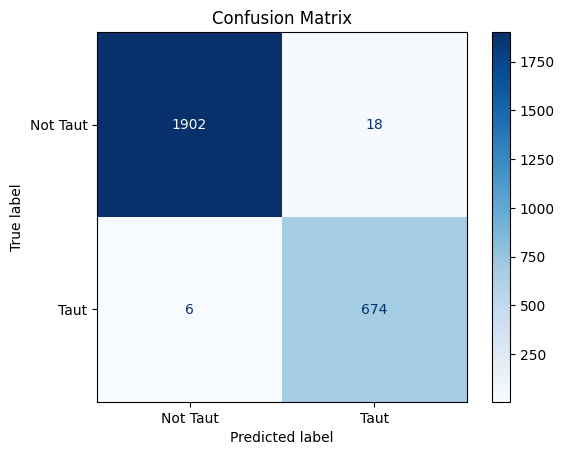

[[1902   18]
 [   6  674]]


In [42]:
# --- Print Confusion Matrix ---
conf_matrix = evaluate_confusion_matrix(model, tree_test_loader, device)
print(conf_matrix)

In [46]:
print(f"The errors are unbalanced: more false positives (18) than false negatives (6)."
      f"\nProportionally: although non-tautologies are the majority class, the model shows a slight tendency to 'overestimate' tautologicity.")

The errors are unbalanced: more false positives (18) than false negatives (6).
Proportionally: although non-tautologies are the majority class, the model shows a slight tendency to 'overestimate' tautologicity.


In [1]:
# --- Confusion Matrix Results ---
print(f"True Negative: 1902 - Non Taut correctly classified."
      f"\nFalse Positive: 18 - Non Taut misclassified as Taut."
      f"\nFalse Negative: 6 - Taut misclassified as Not Taut."
      f"\nTrue Positive: 674 - Taut correctly classified.")

print(f"\n\nAccuracy: (TP + TN) / Total = {(674 + 1902) / 2600:.4f}"
      f"\nThe percentage of correct predictions out of the total.")

precision = 674 / (674 + 18)
recall = 674 / (674 + 6)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\n\nPrecision (Taut): TP / (TP + FP) = {precision:.4f}"
      f"\nNumber of True Tauts in those classified as Tauts.")

print(f"\n\nRecall (Taut): TP / (TP + FN) = {recall:.4f}"
      f"\nNumber of Tauts correctly recognized among the formulas that are truly Tauts.")

print(f"\n\nF1-score (Taut): 2 * (P * R) / (P + R) = {f1:.4f}"
      f"\nHarmonic mean between precision and recall on the tautology class.")

True Negative: 1902 - Non Taut correctly classified.
False Positive: 18 - Non Taut misclassified as Taut.
False Negative: 6 - Taut misclassified as Not Taut.
True Positive: 674 - Taut correctly classified.


Accuracy: (TP + TN) / Total = 0.9908
The percentage of correct predictions out of the total.


Precision (Taut): TP / (TP + FP) = 0.9740
Number of True Tauts in those classified as Tauts.


Recall (Taut): TP / (TP + FN) = 0.9912
Number of Tauts correctly recognized among the formulas that are truly Tauts.


F1-score (Taut): 2 * (P * R) / (P + R) = 0.9825
Harmonic mean between precision and recall on the tautology class.


In [43]:
fp, fn = analyze_model_errors(model, tree_test_loader, device)

print(f"\nFalse Positives ({len(fp)}):")
for i, e in enumerate(fp):
    print(f"{i+1}. {e['formula']} | True: {e['true_label']} | Pred: {e['pred_label']} | Prob: {e['prob']:.4f}")

print(f"\nFalse Negatives ({len(fn)}):")
for i, e in enumerate(fn):
    print(f"{i+1}. {e['formula']} | True: {e['true_label']} | Pred: {e['pred_label']} | Prob: {e['prob']:.4f}")

  0%|          | 0/163 [00:00<?, ?it/s]


False Positives (18):
1. ((((A0 ∨ (A1 ∨ A2)) → A3) ∨ (((¬A4) ∨ A5) ∧ A6)) ∨ ((A7 ∨ A0) ∨ A1)) | True: 0 | Pred: 1 | Prob: 0.5415
2. (((¬(A0 ∧ (A1 ∧ A2))) → ((A3 ∧ (A4 ∨ A5)) → (A6 ∧ A7))) ∨ (¬A0)) | True: 0 | Pred: 1 | Prob: 0.9033
3. (((¬(A0 ∨ A1)) → (((A2 ∨ ⊥) ∧ (⊥ → A3)) ∨ (A4 ∨ A5))) ∨ A0) | True: 0 | Pred: 1 | Prob: 0.5216
4. (((A0 → A1) ∨ ((¬A2) → A3)) ∨ ((((A4 ∨ A5) ∧ (A6 → A7)) → (A0 → (A1 ∨ A2))) ∨ A3)) | True: 0 | Pred: 1 | Prob: 0.8733
5. (((¬((A0 ∧ ⊥) → (A1 ∧ A2))) ∨ ((¬A3) ∧ (⊥ ∧ (¬A4)))) ∨ (A5 → ((¬A0) ∧ (¬(A6 ∧ A1))))) | True: 0 | Pred: 1 | Prob: 0.7597
6. ((((A0 → (A1 ∨ A2)) ∨ ((A3 → ⊥) → A4)) ∨ A5) ∨ ((A6 ∧ A0) → ((¬(A1 ∨ A2)) ∧ ((A3 ∨ A7) → A4)))) | True: 0 | Pred: 1 | Prob: 0.6605
7. ((A0 ∨ A1) ∨ ((((A2 → A3) ∧ A4) ∧ ((¬A5) ∧ (A6 → A7))) → (A0 ∨ (A1 ∧ (A2 ∧ A3))))) | True: 0 | Pred: 1 | Prob: 0.7291
8. ((((A0 ∨ A1) ∧ A2) → ((A3 ∨ (A4 → A5)) ∧ (A6 ∧ (¬A7)))) ∨ (¬A0)) | True: 0 | Pred: 1 | Prob: 0.7695
9. ((((¬A0) → A1) ∨ (((A2 ∨ A3) ∨ ⊥) → (A4 → (A5 ∧ A6)))) ∨ A0) | 

**False Positives: 18 cases**
.......

**False Negatives: 18 casi**
.......

**MANCA ANALISI DELLE FORMULE MISCLASSIFICATE!!!**